## Algorithme de clustering d'images

# 1 - Tri et redimensionnement de images

On importe ici les bibliothèques nécessaire, à savoir Keras pour gérer les algorithmes de clustering non supervisés et OpenCV pour la caractérisation des métriques de chaque cluster

In [41]:
# Importer les bibliothèques nécessaires
import numpy as np
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import os
from glob import glob
import re
import shutil
import cv2

On utilise ici ResNet50, qui est un modèle de réseau de neurones pré-entrainé sur de larges jeux de données. Il se chargera donc de l'extraction automatique de caractéristiques de chaque image, dites "features".

In [42]:
# Charger ResNet50 sans la couche de classification
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [43]:
def extract_features(img, model):
    # Redimensionner l'image à 224x224 pixels
    img = img.resize((224, 224))
    # Convertir l'image en un tableau numpy
    x = image.img_to_array(img)
    # Ajouter une dimension (pour représenter le batch de 1 image)
    x = np.expand_dims(x, axis=0)
    # Prétraiter l'image pour ResNet
    x = preprocess_input(x)
    # Passer l'image dans le modèle pour extraire les features
    features = model.predict(x)
    # Aplatir le vecteur de sortie (c'est déjà un vecteur de 2048, donc facultatif ici)
    return features.flatten()


Sur nos précédents algorithmes, le clustering s'effectuait sur le jeu de données entier. Or, au vu de la dispositions des deux caméras sur le mât de Fécamp, on a des caméras supérieures et inférieures, qui offrent des vues différentes. Le déséquilibre entre ciel et mer sur les images vient donc perturber la qualité de la classification. (Par exemple la mer est plus foncée par défaut que le ciel, donc permet moins bien d'estimer la luminosité globale de l'image). Cependant, la mer est également porteuse d'informations sur les conditions météo, c'est pourquoi on va essayer de séparer le jeu de données en 2, pour pouvoir effectuer des classifications sur ciels et mer séparement.

On réalise 2 fonctions de découpage d'images, une pour les caméras du haut et une pour celle du bas. Le but est, pour les 2 groupes d'images, d'isoler un rectangle de ciel (resp de mer) pour que le clustering se fasse exclusivement en fonction de l'état du ciel (resp de la mer). On peut ensuite appliquer sur ces lots d'images les algorithmes de clustering

In [44]:
from PIL import Image

#Fonction qui découpe un rectangle dans le ciel

from PIL import Image

def decoupe_rectangle_ciel(image):
    # Dimensions du rectangle à découper
    crop_width = 1561
    crop_height = 780

    # Calculer les coordonnées du rectangle à découper
    width, height = image.size
    left = (width - crop_width) / 2
    top = 0
    right = left + crop_width
    bottom = top + crop_height

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image



In [45]:
from PIL import Image

#Fonction qui découpe un rectangle dans la mer

def decoupe_rectangle_mer(image):
    # Dimensions du carré à découper
    crop_size = 820
    offset = 126

    # Calculer les coordonnées du carré à découper au centre de l'image avec décalage à droite
    width, height = image.size
    left = (width - crop_size) / 2 + offset
    top = (height - crop_size) / 2
    right = left + crop_size
    bottom = top + crop_size

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image




 # Séparation des images

ON veut donc appliquer notre algorithme de clustering sur notre lot d'images divisé en deux sous-catégories, photos_ciel et photos_mer

In [46]:
import glob
import numpy as np
import os
from PIL import Image

# Initialiser les listes pour stocker les photos
photos_ciel = []
photos_mer = []

# Listes pour les images découpées
photos_ciel_découpés = []
photos_mer_découpés = []

# Listes pour stocker les features
features_ciel_list = []
features_mer_list = []

# Chemin vers le dossier d'images
dossier_images = "../../DATASET_SENSEA/images"
print(os.path.exists(dossier_images))  # Vérifie si le chemin existe


True


# Algorithme de spéaration des lots !! à éxécuter pour classer les images dans les deux dossiers différents si déjà fait pas besoin !!

On note dans la nomenclature des images que les deux chiffres juste avant -frame indique l'emplacement de la caméra. Ces numéros vont de 00 à 11, et un nombre pair correspond à une caméra supérieure, un nombre impair à une caméra inférieure

In [39]:
# Chemin vers les sous-dossiers photos_ciel et photos_mer
photos_ciel_path = os.path.join(dossier_images, "photos_ciel")
photos_mer_path = os.path.join(dossier_images, "photos_mer")

# Créer les dossiers s'ils n'existent pas déjà
os.makedirs(photos_ciel_path, exist_ok=True)
os.makedirs(photos_mer_path, exist_ok=True)

# Liste de tous les fichiers dans le dossier images
fichiers = [f for f in os.listdir(dossier_images) if f.endswith(".jpg")]

# Expression régulière pour extraire le numéro avant 'frame'
pattern = re.compile(r"-(\d+)_frame")

# Trier les fichiers
for fichier in fichiers:
    # Trouver le chemin complet du fichier
    chemin_complet = os.path.join(dossier_images, fichier)
    
    # Extraire le numéro avant 'frame'
    match = pattern.search(fichier)
    if match:
        numero_frame = int(match.group(1))
        
        # Vérifier si le numéro est pair ou impair
        if numero_frame % 2 == 0:
            # Déplacer vers photos_ciel (nombres pairs)
            shutil.move(chemin_complet, os.path.join(photos_ciel_path, fichier))
            print(f"Déplacé dans photos_ciel : {fichier}")
        else:
            # Déplacer vers photos_mer (nombres impairs)
            shutil.move(chemin_complet, os.path.join(photos_mer_path, fichier))
            print(f"Déplacé dans photos_mer : {fichier}")
    else:
        print(f"Nom de fichier non conforme : {fichier}")

Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=285.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=286.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=287.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=288.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=289.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=290.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=291.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=292.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=293.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=294.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=295.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_frame=296.jpg
Déplacé dans photos_mer : sequence=100_video-20220514_053015-01_

On applique donc notre fonction d'extraction de features sur les deux lots distincts. Le paramètre N permet de décider de la proportion d'images traitées dans le lot, puisqu'il est très large, et comporte de nombreux doublons. On peut ainsi réduire le temps de compilation tout en limitant la perte d'informations.

In [47]:
# Chemin vers les sous-dossiers photos_ciel et photos_mer
photos_ciel_path = os.path.join(dossier_images, "photos_ciel")
photos_mer_path = os.path.join(dossier_images, "photos_mer")

# Paramètres pour réduire le nombre d'images traitées
N = 100  # Traiter une image sur N pour réduire le temps d'exécution

# Liste des images dans chaque dossier
photos_ciel = glob.glob(os.path.join(photos_ciel_path, "*.jpg"))
photos_mer = glob.glob(os.path.join(photos_mer_path, "*.jpg"))

# Afficher la taille des listes photos_ciel et photos_mer
print(f"Nombre d'images dans photos_ciel: {len(photos_ciel)}")
print(f"Nombre d'images dans photos_mer: {len(photos_mer)}")

# Paramétrer un filtrage pour limiter les images traitées (1 image sur N)
photos_ciel_filtered = photos_ciel[::N]
photos_mer_filtered = photos_mer[::N]

# Afficher la taille après filtrage
print(f"Nombre d'images filtrées pour photos_ciel: {len(photos_ciel_filtered)}")
print(f"Nombre d'images filtrées pour photos_mer: {len(photos_mer_filtered)}")

# Découper les images du ciel
for img_path in photos_ciel_filtered:
    with Image.open(img_path) as img:
        extrait_ciel = decoupe_rectangle_ciel(img)  
        photos_ciel_découpés.append(extrait_ciel)

# Afficher la taille de la liste des images découpées pour le ciel
print(f"Nombre d'images découpées pour photos_ciel: {len(photos_ciel_découpés)}")

# Découper les images de la mer
for img_path in photos_mer_filtered:
    with Image.open(img_path) as img:
        extrait_mer = decoupe_rectangle_mer(img)  
        photos_mer_découpés.append(extrait_mer)

# Afficher la taille de la liste des images découpées pour la mer
print(f"Nombre d'images découpées pour photos_mer: {len(photos_mer_découpés)}")

# Extraire les features des images découpées pour le ciel
for img in photos_ciel_découpés:
    features_ciel = extract_features(img, model)
    features_ciel_list.append(features_ciel)  

# Afficher la taille de la liste des features pour le ciel
print(f"Nombre de features extraites pour photos_ciel: {len(features_ciel_list)}")

# Extraire les features des images découpées pour la mer
for img in photos_mer_découpés:
    features_mer = extract_features(img, model)  
    features_mer_list.append(features_mer)

# Afficher la taille de la liste des features pour la mer
print(f"Nombre de features extraites pour photos_mer: {len(features_mer_list)}")

# Convertir les listes de features en tableaux numpy
features_ciel_array = np.array(features_ciel_list)
features_mer_array = np.array(features_mer_list)

# Afficher la forme des tableaux numpy
print(f"Shape of features_ciel_array: {features_ciel_array.shape}")
print(f"Shape of features_mer_array: {features_mer_array.shape}")


Nombre d'images dans photos_ciel: 10834
Nombre d'images dans photos_mer: 9771
Nombre d'images filtrées pour photos_ciel: 109
Nombre d'images filtrées pour photos_mer: 98
Nombre d'images découpées pour photos_ciel: 109
Nombre d'images découpées pour photos_mer: 98
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


On obtient un array comportant toutes les features extraites par le réseau de neurones. On vient réduire ici sa taille à 50 au lieu de 2048 pour simplifier l'éxécution sans non plus perdre trop d'informations

In [48]:
from sklearn.decomposition import PCA

# Supposons que `features_array` soit le tableau de features de 2048 dimensions (chaque ligne est un vecteur de features pour une image)
# Vérifions sa taille pour être sûr
print(features_ciel_array.shape)  # Par exemple, (num_images, 2048)
print(features_mer_array.shape)  

# On applique PCA pour réduire à un nombre de dimensions réduit, ici 50 pour l'exemple
pca = PCA(n_components=50)
reduced_features_ciel = pca.fit_transform(features_ciel_array)
reduced_features_mer = pca.fit_transform(features_mer_array)



# Affichage des dimensions après réduction
print(reduced_features_mer.shape)  # Par exemple, (num_images, 50)
print(reduced_features_ciel.shape) 

(109, 2048)
(98, 2048)
(98, 50)
(109, 50)


# 2 - Clustering des images

La méthode du coude étudie l'inertie en fonction permet du nombre de clusters, et permet de déterminer le nombre optimal de clusters, ce nombre repérsentant la cassure sur la courbe : ici 5

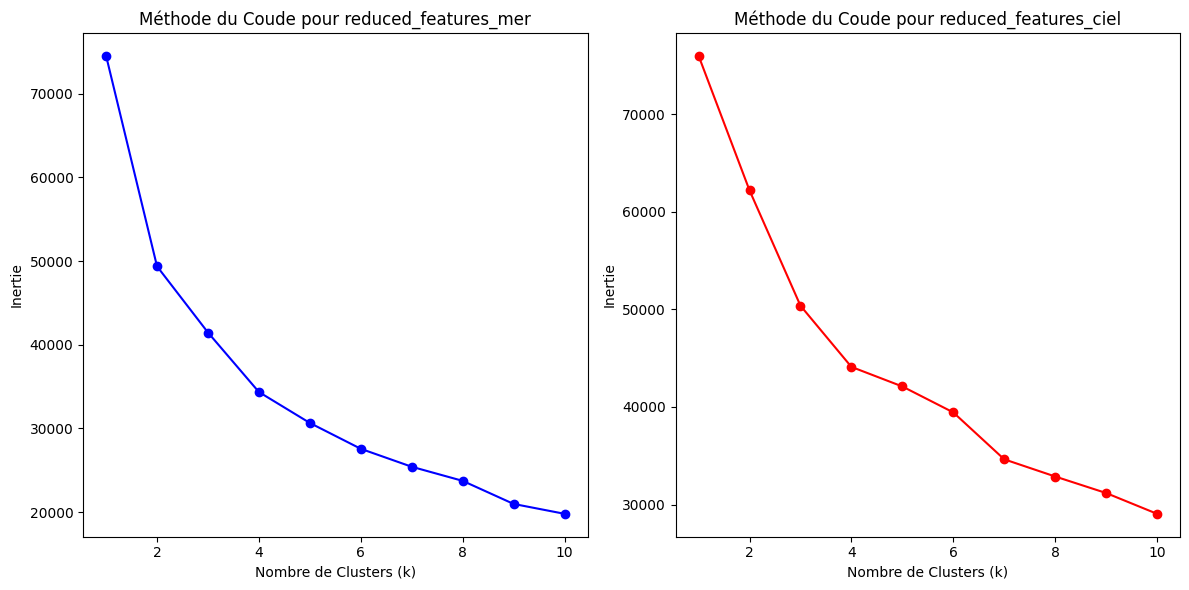

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Liste pour stocker les inerties
inertias_mer = []
inertias_ciel = []

# Tester K-means pour différents nombres de clusters (de 1 à 10)
for k in range(1, 11):
    # Appliquer KMeans sur reduced_features_mer
    kmeans_mer = KMeans(n_clusters=k, random_state=0)
    kmeans_mer.fit(reduced_features_mer)  # Utilisez reduced_features_mer pour la mer
    inertias_mer.append(kmeans_mer.inertia_)

    # Appliquer KMeans sur reduced_features_ciel
    kmeans_ciel = KMeans(n_clusters=k, random_state=0)
    kmeans_ciel.fit(reduced_features_ciel)  # Utilisez reduced_features_ciel pour le ciel
    inertias_ciel.append(kmeans_ciel.inertia_)

# Tracer le graphique de la méthode du coude pour reduced_features_mer
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Premier graphique
plt.plot(range(1, 11), inertias_mer, marker='o', color='b')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_mer')

# Tracer le graphique de la méthode du coude pour reduced_features_ciel
plt.subplot(1, 2, 2)  # Deuxième graphique
plt.plot(range(1, 11), inertias_ciel, marker='o', color='r')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_ciel')

# Afficher les graphiques
plt.tight_layout()
plt.show()


On applique donc un k-means avec un nombre de clusters de 5

In [49]:
from sklearn.cluster import KMeans

# Choisir le nombre optimal de clusters (exemple avec k=5)
k_optimal = 5

# Appliquer K-means pour reduced_features_mer
kmeans_mer = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_mer = kmeans_mer.fit_predict(reduced_features_mer)  # Appliquer K-Means sur reduced_features_mer

# Afficher les étiquettes des clusters pour chaque image de reduced_features_mer
print("Étiquettes des clusters pour reduced_features_mer:")
print(labels_kmeans_mer)

# Appliquer K-means pour reduced_features_ciel
kmeans_ciel = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_ciel = kmeans_ciel.fit_predict(reduced_features_ciel)  # Appliquer K-Means sur reduced_features_ciel

# Afficher les étiquettes des clusters pour chaque image de reduced_features_ciel
print("Étiquettes des clusters pour reduced_features_ciel:")
print(labels_kmeans_ciel)


Étiquettes des clusters pour reduced_features_mer:
[1 1 1 2 2 2 1 1 0 0 1 1 4 4 4 1 1 1 2 2 0 0 0 0 2 2 1 1 2 2 2 2 2 4 4 4 0
 0 0 4 4 4 4 4 4 4 2 2 2 2 2 2 2 0 0 0 1 2 2 2 1 4 4 4 1 1 1 4 4 4 4 2 2 2
 3 3 3 4 4 4 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1]
Étiquettes des clusters pour reduced_features_ciel:
[0 0 4 4 4 0 0 4 3 3 1 3 1 1 1 3 1 1 1 1 1 1 0 1 1 3 1 1 1 1 1 1 1 2 2 2 3
 3 3 0 0 0 0 1 1 1 1 1 4 3 3 3 3 4 3 1 1 0 0 0 4 4 3 4 4 2 2 2 4 4 4 4 4 4
 4 4 3 4 4 2 4 0 0 4 3 4 4 4 4 3 1 1 1 3 0 0 0 0 0 0 4 4 4 4 4 4 3 3 3]


In [26]:
def afficher_photos_aleatoires(images, labels_kmeans, num_photos=50):
    indices = np.random.choice(len(images), num_photos, replace=False)
    nb_colonnes = 10
    nb_lignes = num_photos // nb_colonnes + (num_photos % nb_colonnes > 0)

    plt.figure(figsize=(15, nb_lignes * 1.5))

    for i, idx in enumerate(indices):
        plt.subplot(nb_lignes, nb_colonnes, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Cluster {labels_kmeans[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


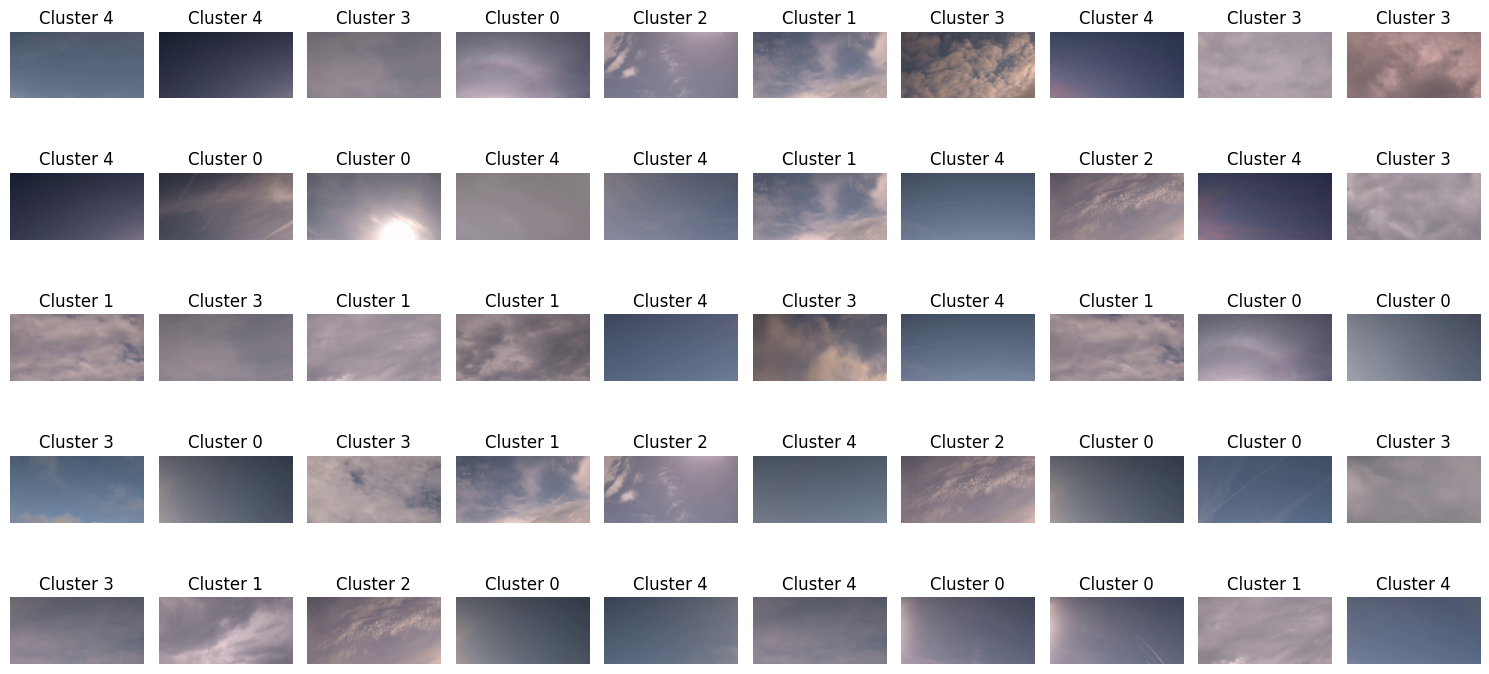

In [50]:
afficher_photos_aleatoires(photos_ciel_découpés, labels_kmeans_ciel, num_photos=50)

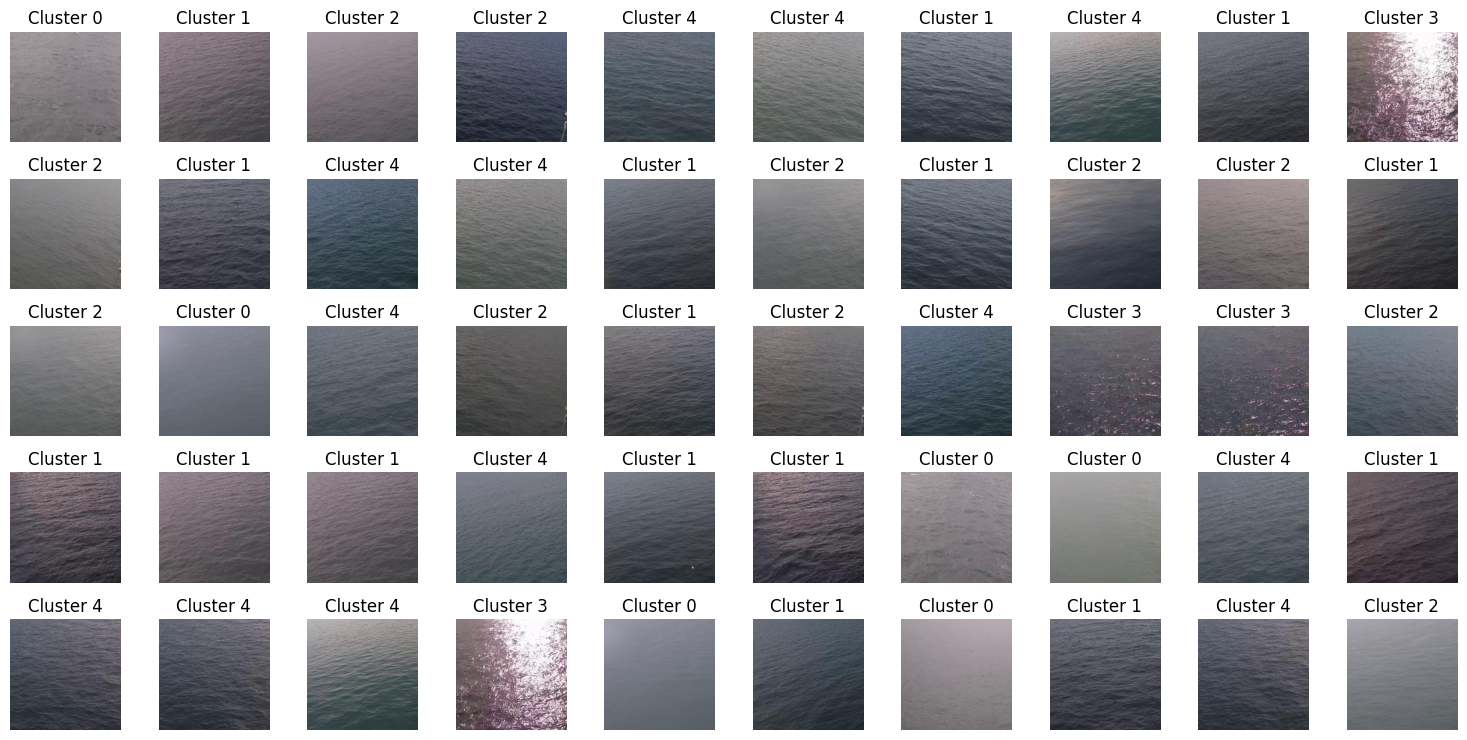

In [51]:
afficher_photos_aleatoires(photos_mer_découpés, labels_kmeans_mer, num_photos=50)

# 3 - Analyse des métriques

L'objectif est maintenant de pouvoir mesurer différentes grandeurs pour pouvoir distinguer et caractériser les clusters selon des paramètres météorologiques, on commence d'abord par les photos de ciel, plus révélatrices de la météo

Les différents paramètres qui vont être combinés sont la luminsoité, le flou, le contraste et le niveau de rouge. On calcule ces métriques avec la bilbiothèque OpenCV, qui est une bibliothèque utile pour extraire manuellement des features d'une image

Luminosité des clusters

In [52]:
cluster_luminosite_ciel = []
for cluster_id in range(k_optimal):
    #Liste des images par clusters
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    #Liste de la luminosité moyenne de chaque image
    mean_luminosities = [np.mean(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)) for img in cluster_images]
    #Obtention de la luminosité moyenne du cluster
    cluster_luminosite_ciel.append(np.mean(mean_luminosities))

# Affichage des valeurs de luminosité moyenne
for i in range(k_optimal) : 
    print ("Luminosité du cluster", i, " : ", cluster_luminosite_ciel[i])

Luminosité du cluster 0  :  115.62958304569361
Luminosité du cluster 1  :  131.458642198871
Luminosité du cluster 2  :  130.494184981685
Luminosité du cluster 3  :  138.22464211358442
Luminosité du cluster 4  :  98.21138115857167


In [53]:
cluster_luminosite_mer = []
for cluster_id in range(k_optimal):
    #Liste des images par clusters
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    #Liste de la luminosité moyenne de chaque image
    mean_luminosities = [np.mean(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)) for img in cluster_images]
    #Obtention de la luminosité moyenne du cluster
    cluster_luminosite_mer.append(np.mean(mean_luminosities))

# Affichage des valeurs de luminosité moyenne
for i in range(k_optimal) : 
    print ("Luminosité du cluster", i, " : ", cluster_luminosite_mer[i])

Luminosité du cluster 0  :  117.31683893515765
Luminosité du cluster 1  :  82.33392423434327
Luminosité du cluster 2  :  107.31336276026174
Luminosité du cluster 3  :  122.15985144424614
Luminosité du cluster 4  :  94.47299698678323


Flou des clusters

In [56]:
def calculer_flou(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var

# Calculer le niveau de flou moyen pour chaque cluster
cluster_flou_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le niveau de flou pour chaque image du cluster
    flous = [calculer_flou(img) for img in cluster_images]
    # Ajouter le niveau de flou moyen du cluster à la liste
    cluster_flou_ciel.append(np.mean(flous) if flous else 0)

for i in range(k_optimal) : 
    print ("Niveau de flou du cluster", i, " : ", cluster_flou_ciel[i])

Niveau de flou du cluster 0  :  0.7247710825828886
Niveau de flou du cluster 1  :  1.5515410499930455
Niveau de flou du cluster 2  :  1.9417226631016031
Niveau de flou du cluster 3  :  1.1440707903460317
Niveau de flou du cluster 4  :  0.3921486815130164


In [55]:
def calculer_flou(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var

# Calculer le niveau de flou moyen pour chaque cluster
cluster_flou_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le niveau de flou pour chaque image du cluster
    flous = [calculer_flou(img) for img in cluster_images]
    # Ajouter le niveau de flou moyen du cluster à la liste
    cluster_flou_mer.append(np.mean(flous) if flous else 0)

for i in range(k_optimal) : 
    print ("Niveau de flou du cluster", i, " : ", cluster_flou_mer[i])

Niveau de flou du cluster 0  :  249.54609884046133
Niveau de flou du cluster 1  :  406.31856674242454
Niveau de flou du cluster 2  :  112.76628530786935
Niveau de flou du cluster 3  :  2510.908208932318
Niveau de flou du cluster 4  :  340.2718829257552


Contraste des clusters

In [57]:
def calculer_contraste(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    contrast = np.std(gray_image)  # Écart type des intensités
    return contrast

# Calculer le contraste moyen pour chaque cluster
cluster_contraste_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le contraste pour chaque image du cluster
    contrastes = [calculer_contraste(img) for img in cluster_images]
    # Ajouter le contraste moyen du cluster à la liste
    cluster_contraste_ciel.append(np.mean(contrastes) if contrastes else 0)

for i in range (k_optimal) : 
    print ("Niveau de contraste du cluster ", i, " : ", cluster_contraste_ciel[i])

Niveau de contraste du cluster  0  :  24.90075826218206
Niveau de contraste du cluster  1  :  18.173917436521034
Niveau de contraste du cluster  2  :  15.826788230586624
Niveau de contraste du cluster  3  :  13.595128344599075
Niveau de contraste du cluster  4  :  13.460792476062492


In [58]:
def calculer_contraste(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    contrast = np.std(gray_image)  # Écart type des intensités
    return contrast

# Calculer le contraste moyen pour chaque cluster
cluster_contraste_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le contraste pour chaque image du cluster
    contrastes = [calculer_contraste(img) for img in cluster_images]
    # Ajouter le contraste moyen du cluster à la liste
    cluster_contraste_mer.append(np.mean(contrastes) if contrastes else 0)

for i in range (k_optimal) : 
    print ("Niveau de contraste du cluster ", i, " : ", cluster_contraste_mer[i])

Niveau de contraste du cluster  0  :  16.72414347573891
Niveau de contraste du cluster  1  :  24.632428169194476
Niveau de contraste du cluster  2  :  20.430327050679367
Niveau de contraste du cluster  3  :  50.782411106196015
Niveau de contraste du cluster  4  :  23.466963512558674


Niveau de rouge des clusters

In [59]:
def calculer_niveau_rouge(image):
    red_channel = np.array(image)[:, :, 2]  # Extraire le canal rouge
    niveau_rouge = np.mean(red_channel)  # Moyenne des valeurs rouges
    return niveau_rouge

# Calculer le niveau moyen des rouges pour chaque cluster
cluster_rouge_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le niveau rouge pour chaque image du cluster
    niveaux_rouges = [calculer_niveau_rouge(img) for img in cluster_images]
    # Ajouter le niveau rouge moyen du cluster à la liste
    cluster_rouge_ciel.append(np.mean(niveaux_rouges) if niveaux_rouges else 0)

# Afficher le niveau moyen des rouges pour chaque cluster
for i in range(k_optimal):
    print("Niveau moyen des rouges du cluster", i, ":", cluster_rouge_ciel[i])

Niveau moyen des rouges du cluster 0 : 128.5240929076266
Niveau moyen des rouges du cluster 1 : 137.77845414201184
Niveau moyen des rouges du cluster 2 : 139.19636810838733
Niveau moyen des rouges du cluster 3 : 142.0100595238095
Niveau moyen des rouges du cluster 4 : 119.67905913564266


In [60]:
def calculer_niveau_rouge(image):
    red_channel = np.array(image)[:, :, 2]  # Extraire le canal rouge
    niveau_rouge = np.mean(red_channel)  # Moyenne des valeurs rouges
    return niveau_rouge

# Calculer le niveau moyen des rouges pour chaque cluster
cluster_rouge_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le niveau rouge pour chaque image du cluster
    niveaux_rouges = [calculer_niveau_rouge(img) for img in cluster_images]
    # Ajouter le niveau rouge moyen du cluster à la liste
    cluster_rouge_mer.append(np.mean(niveaux_rouges) if niveaux_rouges else 0)

# Afficher le niveau moyen des rouges pour chaque cluster
for i in range(k_optimal):
    print("Niveau moyen des rouges du cluster", i, ":", cluster_rouge_mer[i])

Niveau moyen des rouges du cluster 0 : 126.28980976105493
Niveau moyen des rouges du cluster 1 : 89.34427244661428
Niveau moyen des rouges du cluster 2 : 110.48874479476503
Niveau moyen des rouges du cluster 3 : 122.0835656685835
Niveau moyen des rouges du cluster 4 : 103.2061751545405


In [61]:
vecteurs_ciel = []
vecteurs_mer = []

for i in range(k_optimal):
    vecteurs_ciel.append([cluster_luminosite_ciel[i], cluster_flou_ciel[i], cluster_contraste_ciel[i], cluster_rouge_ciel[i]])
    vecteurs_mer.append([cluster_luminosite_mer[i], cluster_flou_mer[i], cluster_contraste_mer[i], cluster_rouge_mer[i]])

print(vecteurs_ciel)
print(vecteurs_mer)


[[np.float64(115.62958304569361), np.float64(0.7247710825828886), np.float64(24.90075826218206), np.float64(128.5240929076266)], [np.float64(131.458642198871), np.float64(1.5515410499930455), np.float64(18.173917436521034), np.float64(137.77845414201184)], [np.float64(130.494184981685), np.float64(1.9417226631016031), np.float64(15.826788230586624), np.float64(139.19636810838733)], [np.float64(138.22464211358442), np.float64(1.1440707903460317), np.float64(13.595128344599075), np.float64(142.0100595238095)], [np.float64(98.21138115857167), np.float64(0.3921486815130164), np.float64(13.460792476062492), np.float64(119.67905913564266)]]
[[np.float64(117.31683893515765), np.float64(249.54609884046133), np.float64(16.72414347573891), np.float64(126.28980976105493)], [np.float64(82.33392423434327), np.float64(406.31856674242454), np.float64(24.632428169194476), np.float64(89.34427244661428)], [np.float64(107.31336276026174), np.float64(112.76628530786935), np.float64(20.430327050679367), np